In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import numpy as np

from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from itertools import combinations
from collections import defaultdict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
X, y = load_iris(return_X_y=True)

In [4]:
X = torch.tensor(X).to(torch.float32)
y = torch.tensor(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.20)

In [6]:
# all transfers to the graphics
cols_graph = list(combinations([0, 1, 2, 3], 2))

In [7]:
cols_graph

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

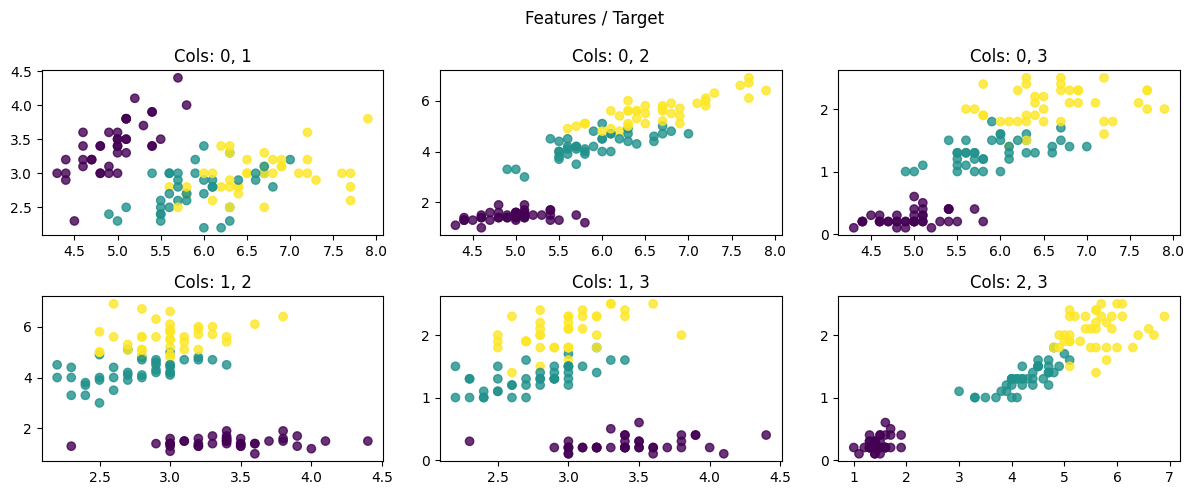

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,5))
fig.suptitle('Features / Target')
for i, (col1, col2) in enumerate(cols_graph):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.scatter(x=X_train[:, col1], y=X_train[:, col2], c=y_train, alpha=0.8)
    ax.set_title(f'Cols: {col1}, {col2}')
plt.tight_layout()
plt.show()

In [9]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.10)

In [10]:
train_data = TensorDataset(X_train, y_train)
eval_data = TensorDataset(X_eval, y_eval)
test_data = TensorDataset(X_test, y_test)

In [11]:
batch_size = 4
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
eval_loader = DataLoader(eval_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=1)

In [12]:
# Criando o modelo
class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(4,8),
            nn.BatchNorm1d(8)
        )
        self.hidden_layer = nn.Sequential(
            nn.Linear(8,6),
            nn.BatchNorm1d(6)
        )
        self.output_layer = nn.Sequential(
            nn.Linear(6, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

In [13]:
model = IrisModel().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(params=model.parameters(), lr=1e-2, weight_decay=1e-5)

In [15]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train_model(data_loader, model, criterion, optimizer, device, epoch):
    model.train()
    epoch_losses = []
    epoch_accs = []
    train_loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)
    for batch_idx, batch in train_loop:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y = y.to(torch.long)
        prediction = model(X)
        loss = criterion(prediction, y)
        accuracy = get_accuracy(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

        train_loop.set_description(f"Epoch: {epoch}")
        train_loop.set_postfix(loss = loss.item(), acc=accuracy)
    return np.mean(epoch_losses), np.mean(epoch_accs)


def eval_model(data_loader, model, criterion, device, epoch):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    eval_loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)
    for batch_idx, batch in eval_loop:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y = y.to(torch.long)
        prediction = model(X)
        loss = criterion(prediction, y)
        accuracy = get_accuracy(prediction, y)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        eval_loop.set_description(f"Epoch: {epoch}")
        eval_loop.set_postfix(loss = loss.item(), acc=accuracy)
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [16]:
# testing the model architecture
x_dummy = torch.rand(6,4).to(device)
y_dummy = torch.randint(0,3, (6,)).to(device)
with torch.no_grad():
    model.eval()
    pred_ = model(x_dummy)
acc = get_accuracy(pred_, y_dummy)
print(f'y: {y_dummy}')
print(f'pred: \n{pred_}')
print(acc)

y: tensor([1, 1, 1, 2, 0, 1], device='cuda:0')
pred: 
tensor([[0.3273, 0.2656, 0.4071],
        [0.3530, 0.2631, 0.3839],
        [0.2969, 0.2466, 0.4565],
        [0.3423, 0.2615, 0.3962],
        [0.2946, 0.2525, 0.4529],
        [0.2977, 0.2519, 0.4504]], device='cuda:0')
tensor(0.1667, device='cuda:0')


In [17]:
EPOCHS = 50
best_valid_loss = float('inf')
metrics = defaultdict(list)

for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(
        data_loader=train_loader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epoch=epoch
    )
    valid_loss, valid_acc = eval_model(eval_loader, model, criterion, device, epoch)
    metrics['train_losses'].append(train_loss)
    metrics['train_accs'].append(train_acc)
    metrics['valid_losses'].append(valid_loss)
    metrics['valid_accs'].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'iris_bestmodel.pt')  # save the best model
    if epoch % 20 == 0:
        print(f'epoch: {epoch}')
        print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
        print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')

epoch: 0
train_loss: 0.907, train_acc: 0.679
valid_loss: 0.822, valid_acc: 0.667


epoch: 20
train_loss: 0.759, train_acc: 0.794
valid_loss: 0.801, valid_acc: 0.771


epoch: 40
train_loss: 0.751, train_acc: 0.806
valid_loss: 0.659, valid_acc: 0.875


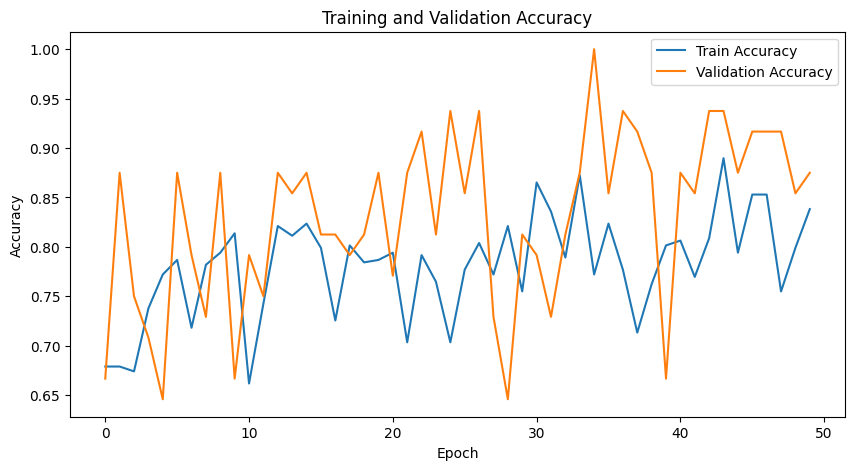

In [18]:
# Plotar gráfico para precisão de treinamento
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_accs'], label='Train Accuracy')
plt.plot(metrics['valid_accs'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

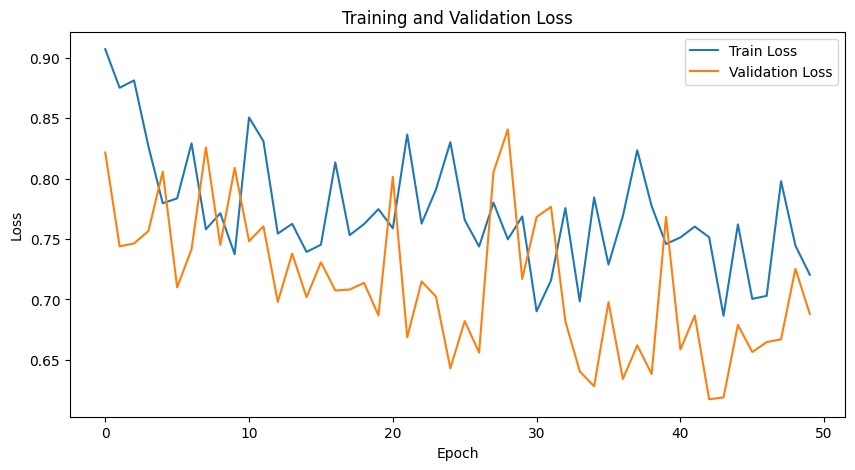

In [19]:
# Plotar gráfico para perdas de treinamento
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_losses'], label='Train Loss')
plt.plot(metrics['valid_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [20]:
y_true = y_test.tolist()
y_preds = []
with torch.no_grad():
    model.eval()
    for batch in test_loader:
        X, y = batch
        X, y = X.to(device), y.to(device)
        pred = model(X)
        y_preds.append(torch.argmax(pred).item())

In [21]:
round(sum(map(lambda x: x[0] == x[1], zip(y_preds, y_true))) / len(y_test), 3)

0.9

In [22]:
# making random predictions
x = torch.tensor([[1.0, 1.0, 1.0, 10.0]], device=device)

In [23]:
@torch.no_grad()
def model_predict(x, model):
    model.eval()
    return torch.argmax(model(x)).item()

In [24]:
model_predict(x, model)

2